In [1]:
import torch

# Dataset imports
from dataloaders.dynamic_edits import DynamicEdits
from PIL import Image
from torchvision import transforms
from transforms.noisify import JpegCompress, Mozaic
from transforms.blurify import MotionBlur
# Stuff for displaying progress
import io
import datetime
import random
import ipywidgets as widgets
from IPython.display import display
from tqdm.notebook import tqdm

# Trainer
import trainers.image_improvement
import trainers.pix2pix
import importlib


In [13]:
def tensor_to_pil(tensor):
    print(tensor.size())
    to_pil = transforms.ToPILImage()
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    return to_pil(image)

In [3]:
def image_to_byte_array(image:Image):
    # Converts a PIL image to byteArray
    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format="png")
    imgByteArr = imgByteArr.getvalue()
    return imgByteArr

In [4]:
def create_out_chain(renders, image_width, image_height):
    image_count = len(renders)
    out_chain = Image.new('RGB', (image_width, image_height))
    widths = [x.width for x in renders]
    for i,im in enumerate(renders):
        w = 0 if i==0 else sum(widths[:i])
        out_chain.paste(im, (w, 0))
    out_chain = image_to_byte_array(out_chain)
    return out_chain

In [5]:
!nvidia-smi

Fri Sep 25 09:47:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  On   | 00000000:01:00.0  On |                  N/A |
| 30%   44C    P0    N/A /  75W |      1MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
model_name = 'fixBlur'
bsize = 4
epoch = 70 #epoch to start
n_epochs = 100 #Epoch to end
html_at = 10
save_epoch_freq = 10
use_latest = False

In [7]:
rc = transforms.RandomChoice([transforms.RandomCrop(256, pad_if_needed=True), transforms.Resize((256,256))])
source_t = transforms.RandomChoice([transforms.RandomCrop(256, pad_if_needed=True), rc])
#rc_effect = transforms.RandomChoice([Mozaic(), MotionBlur(max_size=20)])
target_t = transforms.Compose([MotionBlur(max_size=20), JpegCompress(5,100)])

In [8]:
train_data = DynamicEdits(root='./datasets/hires_fem2', transform=source_t, target_transform=target_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bsize, shuffle=True, num_workers=2)

In [9]:
out_chain = create_out_chain(renders=[tensor_to_pil(x) for x in train_data[0]], image_width=256, image_height=256)

In [14]:
image_container = widgets.Image(
    value=out_chain,
    format='png',
    width=256*3,
    height=256,
)

log_out = widgets.Label(
    value='hello',
)
w = widgets.VBox([image_container, log_out])
display(w)

In [11]:
# create the model
model = trainers.image_improvement.ImageImprovementTrainer(model_name=model_name, epoch=epoch, use_latest=use_latest)

In [23]:
# Training loop
it = 1
for ep in range(epoch,n_epochs):
    for batch_idx, data in tqdm(enumerate(train_loader), total=html_at):
        it += 1
        losses, resulting_image = model.step(inputs=data)
        out_txt = [ f"[{ep:05d}/{n_epochs:05d}][{batch_idx:05d}/{len(train_loader):05d}]"]
        for k,v in losses:
            out_txt.append(f"{k}:{v:.4f}")
        message = " ".join(out_txt)
        log_out.value=message

        if (it % html_at) == 0 or (ep==0 and batch_idx==0):
            model.save('latest')
            renders = [tensor_to_pil(x) for x in [data[0][0], resulting_image[0][0], data[1][0]]]
            image_width = 256*3
            image_height = 256
            c = create_out_chain(renders, image_width, image_height)
            image_container.value = c
            image_container.width = image_width
            image_container.height = image_height

    if ep % save_epoch_freq == 0:
        model.save('%d' % ep)
        log_out.value=f"saved model(s) {ep}"

    now=datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    s = f"epoch {ep} completed. {now}"
    log_out.value = s
    # End single epoch

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])



KeyboardInterrupt: 

In [20]:
[*[i[0].size() for i in resulting_image][0]]

[3, 256, 256]

In [18]:
resulting_image[0].size()

torch.Size([4, 3, 256, 256])

In [40]:
#first image of the returned batch
# ie a list of images to be shown
[1,2, *[i[0] for i in resulting_image][0],3,4]

[1,
 2,
 tensor([[0.5852, 0.5589, 0.5666,  ..., 0.5140, 0.5205, 0.5087],
         [0.6139, 0.5709, 0.5768,  ..., 0.4938, 0.5149, 0.5259],
         [0.6004, 0.5606, 0.5846,  ..., 0.4944, 0.5447, 0.5163],
         ...,
         [0.5675, 0.5468, 0.5601,  ..., 0.5710, 0.5678, 0.5877],
         [0.5542, 0.5573, 0.5464,  ..., 0.5725, 0.5798, 0.5695],
         [0.5531, 0.5521, 0.5547,  ..., 0.5501, 0.5499, 0.5685]],
        device='cuda:0'),
 tensor([[0.5179, 0.5176, 0.4989,  ..., 0.4403, 0.4908, 0.4753],
         [0.5317, 0.5062, 0.4823,  ..., 0.4578, 0.4501, 0.4645],
         [0.5186, 0.5164, 0.5290,  ..., 0.4382, 0.5131, 0.4602],
         ...,
         [0.4850, 0.5026, 0.4698,  ..., 0.5260, 0.5158, 0.5357],
         [0.4980, 0.4928, 0.5079,  ..., 0.5235, 0.5467, 0.5236],
         [0.4793, 0.4993, 0.4888,  ..., 0.5127, 0.4740, 0.5097]],
        device='cuda:0'),
 tensor([[0.4334, 0.4089, 0.4146,  ..., 0.3596, 0.3715, 0.3480],
         [0.4440, 0.4480, 0.4083,  ..., 0.3644, 0.3701, 0.3547],


torch.Size([3, 256, 256])


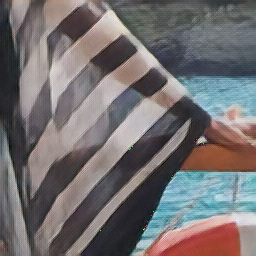

In [21]:
tensor_to_pil([i[0] for i in resulting_image][0].cpu())

In [37]:
[x[0] for x in resulting_image]

[tensor([[[0.5852, 0.5589, 0.5666,  ..., 0.5140, 0.5205, 0.5087],
          [0.6139, 0.5709, 0.5768,  ..., 0.4938, 0.5149, 0.5259],
          [0.6004, 0.5606, 0.5846,  ..., 0.4944, 0.5447, 0.5163],
          ...,
          [0.5675, 0.5468, 0.5601,  ..., 0.5710, 0.5678, 0.5877],
          [0.5542, 0.5573, 0.5464,  ..., 0.5725, 0.5798, 0.5695],
          [0.5531, 0.5521, 0.5547,  ..., 0.5501, 0.5499, 0.5685]],
 
         [[0.5179, 0.5176, 0.4989,  ..., 0.4403, 0.4908, 0.4753],
          [0.5317, 0.5062, 0.4823,  ..., 0.4578, 0.4501, 0.4645],
          [0.5186, 0.5164, 0.5290,  ..., 0.4382, 0.5131, 0.4602],
          ...,
          [0.4850, 0.5026, 0.4698,  ..., 0.5260, 0.5158, 0.5357],
          [0.4980, 0.4928, 0.5079,  ..., 0.5235, 0.5467, 0.5236],
          [0.4793, 0.4993, 0.4888,  ..., 0.5127, 0.4740, 0.5097]],
 
         [[0.4334, 0.4089, 0.4146,  ..., 0.3596, 0.3715, 0.3480],
          [0.4440, 0.4480, 0.4083,  ..., 0.3644, 0.3701, 0.3547],
          [0.4460, 0.4058, 0.4333,  ...,